In [1]:
import os
os.chdir("../")
import numpy as np
import cv2
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from src.factory.config_factory import cfg, show_configs
from src.factory.data_factory import DataFactory
from src.factory.data_format_factory import DataFormatFactory
from src.factory.transform_factory import TransformFactory
from src.factory.loader_factory import LoaderFactory
from src.base_data import BaseData
from tools.logger import setup_logger
logger = setup_logger("./external/")

from tools.scopehead_utils import scopehead_bbox_target

In [2]:
from PIL import Image
import shutil
import cv2
def to_pil(cv_img):
    img = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB)
    return Image.fromarray(img)

In [3]:
cfg.NUM_WORKERS = 1
cfg.DB.PATH = "/media/acer/5f45949f-0fc7-4475-965b-e61989afcc10/Downloads/person_jde"
cfg.DB.DATA = "crowdhuman" #"crowdhuman cuhksysu ethz prw caltech cityperson crowdhuman "
cfg.DB.DATA_FORMAT = "coco"
cfg.DB.TARGET_FORMAT = "fsaf"
cfg.DB.LOADER = "coco"
cfg.DB.USE_TRAIN = True
cfg.DB.USE_TEST = True
cfg.INPUT.SIZE = (512,512)
cfg.INPUT.TRAIN_BS = 2
cfg.INPUT.TEST_BS = 1
cfg.MODEL.STRIDES = [4,8,16,32]
cfg.DB.TRAIN_TRANSFORM = "ResizeKeepAspectRatio RandomHFlip RandomColorJitter-0.8-0.15-0.15-0.1-0.1 Tensorize"
cfg.DB.TEST_TRANSFORM = "ResizeFit Tensorize"
cfg.COCO.TARGET = 'person'
# cfg.YOLO.ANCHORS = [6,16, 8,23, 11,32, 16,45,   21,64, 30,90, 43,128, 60,180,   85,255, 120,360, 170,420, 340, 320]


In [ ]:
data = DataFactory.produce(cfg) #, cfg.DB.PATH, cfg.DB.DATA, 'person', 0, 1, [1], None, True, False)
trans = TransformFactory.produce(cfg, cfg.DB.TRAIN_TRANSFORM)
dataset = DataFormatFactory.produce(cfg, data.train, trans)

In [4]:
loader = LoaderFactory.produce(cfg)

loading annotations into memory...
Done (t=1.66s)
creating index...
index created!
2020-06-12 09:08:14,745 1624 coco.py INFO: => CROWDHUMAN TRAIN is loaded
2020-06-12 09:08:14,746 1624 coco.py INFO:   Dataset statistics:
2020-06-12 09:08:14,747 1624 coco.py INFO:   -----------------------------
2020-06-12 09:08:14,749 1624 coco.py INFO:   subset   | #id     | # images
2020-06-12 09:08:14,751 1624 coco.py INFO:   -----------------------------
2020-06-12 09:08:14,752 1624 coco.py INFO:   train    |       0 |    14982
2020-06-12 09:08:14,753 1624 coco.py INFO:   -----------------------------
[ResizeKeepAspectRatio, RandomHFlip, RandomColorJitter, Tensorize]
loading annotations into memory...
Done (t=0.53s)
creating index...
index created!
2020-06-12 09:08:15,425 1624 coco.py INFO: => CROWDHUMAN VAL is loaded
2020-06-12 09:08:15,426 1624 coco.py INFO:   Dataset statistics:
2020-06-12 09:08:15,426 1624 coco.py INFO:   -----------------------------
2020-06-12 09:08:15,427 1624 coco.py INFO: 

In [ ]:
# batch = next(iter(loader['train']))
for idx, batch in enumerate(loader['train']):
    if idx == 2:
        break

In [ ]:
batch[(16,16)]['hm']

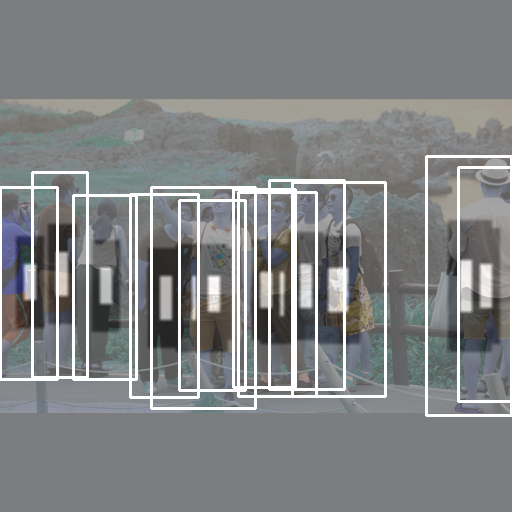

In [11]:
for idx, batch in enumerate(loader['train']):
    if idx == 2:
        break
img = batch['inp'][0]
np_img = (img.permute(1,2,0).numpy() * 255).astype(np.uint8)
np_img = cv2.resize(np_img, (512,512))
hm = batch[(16,16)]['hm'][0]
np_hm = (hm.permute(1,2,0).numpy())
np_hm[np_hm == -1] = 50
np_hm[np_hm == 1] = 255
np_hm[np_hm == 0] = 125
np_hm = np_hm.astype(np.uint8)
np_hm = cv2.resize(np_hm, (512,512)).reshape(512,512,-1).repeat(repeats=3, axis=-1)
vis_img = cv2.addWeighted(np_img, 0.3, np_hm, 0.7, 0.0)
bboxes = batch['bboxes'][0]
bboxes[:,[0,2]] *= 512
bboxes[:,[1,3]] *= 512
for bbox in bboxes:
    x1, y1, x2, y2, score = bbox
    if score > 0:
        cv2.rectangle(vis_img, (int(x1), int(y1)), (int(x2), int(y2)), (255,255,255), 2)
    break
to_pil(vis_img)

In [ ]:
import numpy as np

In [ ]:
a = np.array((5,5))

In [ ]:
a

In [ ]:
import math
def rotate_A(level, shape, **kwargs):
    # copy from https://pillow.readthedocs.io/en/stable/_modules/PIL/Image.html#Image.rotate
    angle = level % 360.0

    w, h = shape

    post_trans = (0, 0)
    rotn_center = (w / 2.0, h / 2.0)
    angle = math.radians(angle)
    matrix = [
        round(math.cos(angle), 15),
        round(math.sin(angle), 15),
        0.0,
        round(-math.sin(angle), 15),
        round(math.cos(angle), 15),
        0.0,
    ]

    def transform(x, y, matrix):
        (a, b, c, d, e, f) = matrix
        return a * x + b * y + c, d * x + e * y + f

    matrix[2], matrix[5] = transform(
        -rotn_center[0] - post_trans[0], -rotn_center[1] - post_trans[1], matrix
    )
    matrix[2] += rotn_center[0]
    matrix[5] += rotn_center[1]

    return np.array(matrix).reshape(2, 3).astype(np.float)
def apply_A(pt, A):
    new_pt = np.array([pt[0], pt[1], 1.], dtype=np.float32).T
    new_pt = np.dot(A, new_pt)
    return new_pt[:2]

In [ ]:
output = torch.zeros(2,5*2,512,512)
output[:,5:7,...] = 1
output[:,:3,...] = 1

In [ ]:
output[0,:,0,0].new_tensor([5,5])

In [ ]:
pred = _tranpose_and_gather_feat(output, ind)
pred_mask = reg_mask.unsqueeze(2).expand_as(pred).bool()
wh_mask = reg_mask.unsqueeze(2).expand_as(wh).bool()

In [ ]:
a = torch.rand(1,100,1)
b = torch.rand(1,100,1)
(a*b).shape

In [ ]:
ordinal_wh = pred.view(2, -1, 2, 5)

In [ ]:
ordinal_wh[0,0]

In [ ]:
(ordinal_wh >= 0.5).sum(dim=-1)

In [ ]:
wh_mask.sum(dim=-1)

In [ ]:
ordinal_wh = pred.view(2, 100, 2, 5, 2)
rank = ordinal_wh.max(dim=-1)[1].sum(dim=-1)

In [ ]:
rank.shape

In [ ]:
crit = nn.BCEWithLogitsLoss()

In [ ]:
pred[pred_mask].reshape(-1, 2)

In [ ]:
wh[0,0]

In [ ]:
(wh * wh_mask).shape

In [ ]:
pred[pred_mask].reshape(-1)

In [ ]:
(wh * wh_mask).view(-1)[:10]

In [ ]:
pred[pred_mask].view(-1).shape

In [ ]:
pred_mask[...] = False
wh_mask[...] = False

In [ ]:
crit(pred[pred_mask].view(-1), wh[wh_mask].view(-1).float())# / (wh_mask.sum() + 1e-4)

In [ ]:
crit((pred * pred_mask).view(-1), (wh * wh_mask).view(-1).float()) / wh_mask.sum()

In [ ]:
torch.sigmoid(torch.Tensor([0]))

In [ ]:
wh[mask.sum(dim=-1).bool()]

In [ ]:
pred[mask].reshape(1,-1,4,5).max(dim=-1)[1]

In [ ]:
data_names = cfg.DB.DATA.split(" ")
handles = []
indice = []
pids = []
offset = 0
for idx, name in enumerate(data_names):
    data = DataFactory.produce(cfg, data_name=name)
    handles.append(data.train['handle'])
    pids.append(data.train['pid'])
    for img_id, img_path in data.train['indice']:
        indice.append((img_id, img_path, idx, offset))
    offset += (max(list(data.train['pid'].values())) + 1)

_data = BaseData()
_data.train['handle'] = handles
_data.train['indice'] = indice
_data.train['pid'] = pids
_data.train['strides'] = cfg.MODEL.STRIDES
_data.train['num_classes'] = offset
_data.train['num_keypoints'] = 0
_data.train['num_person'] = 0
cfg.DB.NUM_CLASSES = offset

trans = TransformFactory.produce(cfg, cfg.DB.TRAIN_TRANSFORM)
dataset = DataFormatFactory.produce(cfg, _data.train, trans)

In [ ]:
batch = dataset[0]

In [ ]:
loader = LoaderFactory.produce(cfg)


In [ ]:
import pycocotools.coco as coco
import json
import os
import os.path as osp
from PIL import Image
from tqdm import tqdm
import numpy as np
import shutil
import cv2

from tools.yolov3_utils import decode_delta_map


In [ ]:
batch = next(iter(loader['train']))
batch['bboxes']
bboxes = np.vstack(batch['bboxes'])
bboxes[:, [0,2]] *= 576
bboxes[:, [1,3]] *= 320

In [ ]:
h

In [ ]:
idx = 0
batch = next(iter(loader['train']))
np_img = (batch['inp'][idx]*255).permute(1,2,0).numpy().astype(np.uint8)
h, w = np_img.shape[:2]
bboxes = np.vstack(batch['bboxes'][idx])
bboxes[:, [0,2]] *= w
bboxes[:, [1,3]] *= h
np_img = cv2.resize(np_img, (w, h))
Image.fromarray(np_img)
for b in bboxes:
    x1, y1, x2, y2 = b
    cv2.rectangle(np_img, (int(x1), int(y1)), (int(x2), int(y2)), (255,255,0), 2)
Image.fromarray(np_img)

In [ ]:
shapes = ['72x40', '36x20', '18x10']
anchors = torch.Tensor(cfg.YOLO.ANCHORS).view(len(cfg.MODEL.STRIDES), -1, 2)
for stage, shape in enumerate(shapes):
    mask = batch[f"yolov3_{shape}_t_conf"] > 0
    t_bbox = batch[f"yolov3_{shape}_t_bbox"]
    print(mask.sum(), shape)
    target_anchors = anchors[stage] / cfg.MODEL.STRIDES[stage]
    p_bbox = decode_delta_map(t_bbox, target_anchors)[mask] * cfg.MODEL.STRIDES[stage]
    p_bbox[:,0] -= p_bbox[:,2] / 2
    p_bbox[:,1] -= p_bbox[:,3] / 2
    for b in p_bbox:
        x1, y1, w, h = b
        cv2.rectangle(np_img, (int(x1), int(y1)), (int(x1+w), int(y1+h)), (0,0,225//(stage+1)), 2)
Image.fromarray(np_img)